# TM10007 Assignment template

In [3]:
# # Run this to use from colab environment
!git clone https://github.com/BrianvanWinden/TM10007_Group_13.git
!unzip "/content/TM10007_Group_13/ecg/ecg_data.zip"
import pandas as pd 

data = pd.read_csv("ecg_data.csv") 

# print(data.head())

fatal: destination path 'TM10007_Group_13' already exists and is not an empty directory.
Archive:  /content/TM10007_Group_13/ecg/ecg_data.zip
replace ecg_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [4]:
# General packages
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import datasets as ds
from scipy.stats import randint
from zipfile import ZipFile
from scipy import stats


# Classifiers and kernels
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn import preprocessing, metrics
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

# Regularization
from sklearn.linear_model import Lasso, RidgeClassifier
from sklearn.feature_selection import SelectFromModel

# Model selection
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, learning_curve, ShuffleSplit, StratifiedKFold
from sklearn.pipeline import Pipeline


## Definition of functions
- Preprocessing data
- Learning curves
- Colorplots
- Evaluation (confusion matrix)
- Cross-validation pipeline

In [5]:

# Data loading functions

def preprocessing_data(data):
    data_points= data.drop(['label'], axis=1).to_numpy()
    data_labels= data['label'].to_numpy()

    sick = sum(data_labels) # 146 

    # Missing values
    missing_values = data.isna().sum()
    number_missing_values = missing_values.astype(bool).sum(axis=0)

    # checking for outliers
    z = np.abs(stats.zscore(data))
    x = np.where(z>3)
    #print(len(x[1])) # number of outliers -> robust scaler

    # Splitting
    # lecture 2.3 20% test set, and 15% van de train set is validatie
    x_train_val, x_test, y_train_val, y_test = train_test_split(data_points, data_labels, test_size=0.2, stratify=data_labels)

    # x_train_trans_df = pd.DataFrame(x_train_trans, columns=['PC1', 'PC2', 'PC3', 'PC4'])
    # y_train_df = pd.DataFrame(y_train, columns=['label'])
    # xy_plot = pd.concat([x_train_trans_df, y_train_df], axis=1)
    # pc_pairplot = sns.pairplot(xy_plot, hue='label', palette='tab10')
    
    return x_train_val, x_test, y_train_val, y_test


# Learning curve

def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")
    return plt


# Colorplots features and boundaries

def colorplot(clf, ax, x, y, h=100, precomputer=None):
    '''
    Overlay the decision areas as colors in an axes.
    
    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    features = np.c_[xx.ravel(), yy.ravel()]
    if precomputer is not None:
        if type(precomputer) is RBFSampler:
            features = precomputer.transform(features)
        elif precomputer is rbf_kernel:
            features = rbf_kernel(features, X)
            
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(features)
    else:
        Z = clf.predict_proba(features)
    if len(Z.shape) > 1:
        Z = Z[:, 1]
    
    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm


# Evaluation confusion matrix

def evaluation(y_val, y_pred, title = 'Confusion Matrix'):
    cm = confusion_matrix(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    print('Recall: ', recall)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show()


# Cross-validation pipeline

def cross_validate(classifier, cv, x_train_trans, y_train_trans, x_val_trans, y_val_trans):

    pipeline = Pipeline(steps=[
        ('preprocess', preprocessing_data),
        ('classifier', classifier)
    ])
    train_acc = []
    test_acc = []
    for train_ind, val_ind in cv.split(X_train, y_train):
        X_t, y_t = X_train.iloc[train_ind], y_train[train_ind]
        pipeline.fit(X_t, y_t)
        y_hat_t = pipeline.predict(X_t)
        train_acc.append(accuracy_score(y_t, y_hat_t))
        X_val, y_val = X_train.iloc[val_ind], y_train[val_ind]
        y_hat_val = pipeline.predict(X_val)
        test_acc.append(accuracy_score(y_val, y_hat_val))
    print(evaluation(y_val, y_hat_val))
    print('Training Accuracy: {}'.format(np.mean(train_acc)))
    print('\n')
    print('Validation Accuracy: {}'.format(np.mean(test_acc)))
    print('\n')



In [4]:
# Creëren standaard classifiers
svmlin = SVC(kernel='linear', gamma='scale', class_weight='balanced')
svmrbf = SVC(kernel='rbf', gamma='scale', class_weight='balanced')
svmpoly = SVC(kernel='poly', degree=3, gamma='scale', class_weight='balanced')
KNN = KNeighborsClassifier(n_neighbors=15)
RFC = RandomForestClassifier(n_estimators = 100, class_weight='balanced')
clsfs = [KNN, RFC, svmlin, svmpoly, svmrbf]
# classifier = svmlin



# Start code: 
*   Verdelen Train - Validatie
*   Scalen 
*   PCA
*   Toepassen Classifiers 
*   



In [30]:
# # Data inladen VSC 
# from ecg.load_data import load_data
# data = load_data()

x_train_val, x_test, y_train_val, y_test = preprocessing_data(data)

# Train - Validatie m.b.v. Crossvalidatie 
cv_outer = StratifiedKFold(n_splits=2)

# Benodigdheden voorbeeld later + standaard goed om te hebben 
results = []
best_n_neigbors = []
scores  = []
num = 0

for train_index, validation_index in cv_outer.split(x_train_val,y_train_val):
  x_train = x_train_val[train_index]
  x_val = x_train_val[validation_index]

  y_train = y_train_val[train_index]
  y_val = y_train_val[validation_index]

  #Scaling
  # Robust scaler omdat er mogelijk sprake is van outliers, median wordt er dan vanaf gehaald en niet de mean die wordt beinvloed door de outliers.
  scaler = preprocessing.RobustScaler()
  scaler.fit(x_train)

  x_train_scaled = scaler.transform(x_train)
  x_val_scaled = scaler.transform(x_val)
  x_test_scaled = scaler.transform(x_test)  

# PCA
  # pca = pca.fit(x_train_scaled)
  # x_train_trans = pca.transform(x_train_scaled)
  # x_val_trans = pca.transform(x_val_scaled)
  # x_test_trans = pca.transform(x_test_scaled)
  # explained_variance = pca.explained_variance_ratio_

  # Feature s election Penalty 
  lsvc = LinearSVC(C=0.01, penalty='l1', dual=False) # Dual = true --> features > Samples 
  model = SelectFromModel(lsvc)
  model = model.fit(x_train_scaled, y_train)

  x_train_penalty = model.transform(x_train_scaled)
  x_val_penalty = model.transform(x_val_scaled)
  x_test_penalty = model.transform(x_test_scaled)
  print(x_train_penalty.shape)
  
  # PCA
  pca = PCA(n_components=0.99)  # Volgens literatuur een algemene, maar strenge maat (95% is de standaard)
  pca= pca.fit(x_train_penalty)
  x_train_trans = pca.transform(x_train_penalty)
  x_val_trans = pca.transform(x_val_penalty)
  x_test_trans = pca.transform(x_test_penalty)
  print(x_train_trans.shape)




  cv_inner = StratifiedKFold(n_splits=3)  # Volgens internet vaak lager dan outer (kan ook andersom)

  #### Random/Grid search + classifier  (VB KNN)
  model_params = {
      'svm':{
          'model': SVC(gamma='scale', class_weight='balanced'),
          'params': {
              'C': [0.1, 1, 10],
              # 'kernel': ['rbf', 'linear']
              'kernel': ['linear']
          }
      },
      # 'rfc':{
      #   'model': RandomForestClassifier(),
      #   'params': {
      #       'n_estimators': [1, 5, 10]
      #   }
      # },
      # 'knn':{
      #     'model': KNeighborsClassifier(),
      #     'params': {
      #         'n_neighbors': list(range(1,18,4))
      #     }
      # },
      'linsvc': {
          'model': LinearSVC(class_weight='balanced', dual=False),  # dual = false, vanwege feature selection: samples > features 
          'params':{
              'C': [0.1, 1, 10]
          }
        }
      
  }
  
  for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv = cv_inner, scoring = 'roc_auc', return_train_score=True)
    clf.fit (x_train, y_train)

  scores[num] = pd.DataFrame(clf.cv_results_['mean_train_score'])
  num+=1
  print(num)

    
    

df1 = pd.DataFrame(clf.cv_results_['params']) 
scores ['avg'] = scores.mean(axis=1)

df = pd.concat([df1, scores], axis=1)
df








(330, 26)
(330, 15)


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

IndexError: ignored

In [29]:
# df1 = pd.DataFrame(clf.cv_results_['params']) 
# df1 

df1 = pd.DataFrame(clf.cv_results_['params']) 
df1 [num] = pd.DataFrame(clf.cv_results_['mean_train_score']) 
df1





,C,2
0,0.1,1.0
1,1.0,1.0
2,10.0,1.0


In [ ]:
# # Load data and create classifiers

# # Data
# from ecg.load_data import load_data
# data = load_data()

# x_train_trans, y_train, x_test_trans, y_test = preprocessing_data(data)

# X = x_train_trans
# Y = y_train

# # Classifiers
# # param_distributions_svm = {}
# # param_distributions = {'n_estimators': randint(1, 400)}
# # svmlin = RandomizedSearchCV(SVC(kernel='linear', gamma='scale'), param_distributions_svm, cv=5, n_iter=20, random_state=42)
# # svmrbf = RandomizedSearchCV(SVC(kernel='rbf', gamma='scale'), param_distributions_svm, cv=5, n_iter=20, random_state=42)
# # svmpoly = RandomizedSearchCV(SVC(kernel='poly', degree=3, gamma='scale'), param_distributions_svm, cv=5, n_iter=20, random_state=42)
# # RF = RandomizedSearchCV(RandomForestClassifier(), param_distributions, cv=5, n_iter=20, random_state=42)
# # LDA = RandomizedSearchCV(LinearDiscriminantAnalysis(), param_distributions, cv=5, n_iter=20, random_state=42)
# # KNN = RandomizedSearchCV(KNeighborsClassifier(), param_distributions, cv=5, n_iter=20, random_state=42)
# # clsfs = [svmlin,svmrbf,svmpoly,RF,LDA,KNN]
# svmlin = SVC(kernel='linear', gamma='scale')
# svmrbf = SVC(kernel='rbf', gamma='scale')
# svmpoly = SVC(kernel='poly', degree=3, gamma='scale')
# clsfs = [KNeighborsClassifier(), RandomForestClassifier(), svmlin, svmpoly, svmrbf]



Misclassified: 35 / 199 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')
Recall:  0.0
Accuracy:  0.8241206030150754
Precision:  0.0
F1:  0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


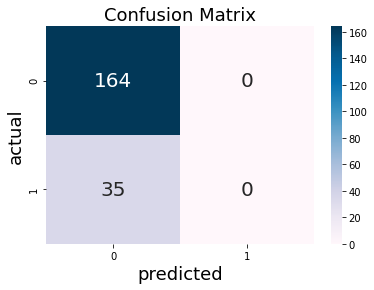

Misclassified: 35 / 199 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Recall:  0.0
Accuracy:  0.8241206030150754
Precision:  0.0
F1:  0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


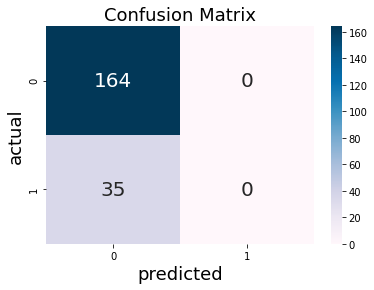

Misclassified: 40 / 199 SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Recall:  0.2
Accuracy:  0.7989949748743719
Precision:  0.3684210526315789
F1:  0.25925925925925924


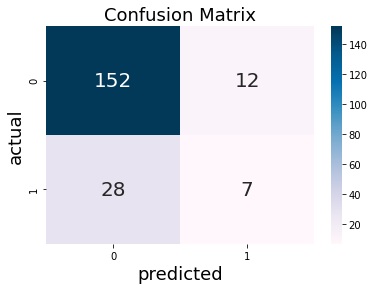

Misclassified: 35 / 199 SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Recall:  0.0
Accuracy:  0.8241206030150754
Precision:  0.0
F1:  0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


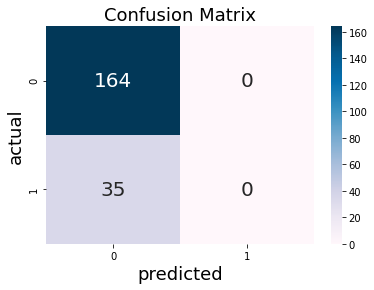

Misclassified: 44 / 199 SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Recall:  0.05714285714285714
Accuracy:  0.7788944723618091
Precision:  0.15384615384615385
F1:  0.08333333333333333


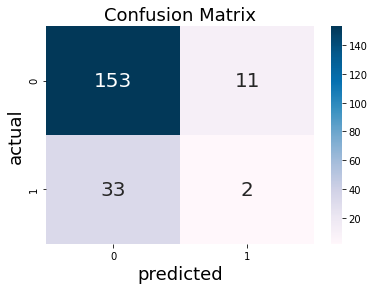

In [ ]:
# Plot classifications
lsvc = LinearSVC(C=0.01, penalty='l1', dual=False) # Dual = true --> features > Samples 
model = SelectFromModel(lsvc)
model = model.fit(x_train_scaled, y_train)

X = x_train_val_trans
Y = y_test

# num = 0
# fig = plt.figure(figsize=(24,8*len(clsfs)))
# ax = fig.add_subplot(7, 3, num + 1)
# ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y, 
#            s=25, edgecolor='k', cmap=plt.cm.Paired)

classifier = LinearSVC(class_weight='balanced', dual=False, c=1)

clf.fit(X, Y)
# ax = fig.add_subplot(7, 3, num + 1)
# ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
#     s=25, edgecolor='k', cmap=plt.cm.Paired)
# colorplot(clf, ax, X[:, 0], X[:, 1])
y_pred = clf.predict(x_test_trans)
accuracy = metrics.accuracy_score(y_test, y_pred)
# best = clf.best_estimator_
print('Misclassified: %d / %d' % ((y_val != y_pred).sum(), x_val_trans.shape[0]), str(clf))
evaluation(y_val, y_pred)
# ax.set_title(t)
# num += 1





In [ ]:
# Learning Curve

X = x_train_trans
Y = y_train

num = 0
fig = plt.figure(figsize=(24,8*len(clsfs)))
ax = fig.add_subplot(7, 3, num + 1)
ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y, 
           s=25, edgecolor='k', cmap=plt.cm.Paired)

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
num = 1
for clf in clsfs:
    # Split data in training and testing
    title = str(clf)
    ax = fig.add_subplot(7, 3, num + 1)
    plot_learning_curve(clf, title, X, Y, ax, ylim=(0.3, 1.01), cv=cv)
    num += 1

Best classifier: k=3
Best classifier: k=25
Best classifier: k=7
Best classifier: k=9
Best classifier: k=9
Best classifier: k=13
Best classifier: k=9
Best classifier: k=9
Best classifier: k=3
Best classifier: k=9
Best classifier: k=3
The optimal N=9


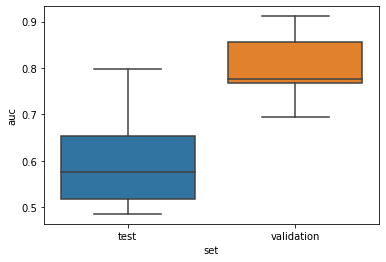

In [ ]:

# Create a 20 fold stratified CV iterator
cv_20fold = StratifiedKFold(n_splits=11)
results = []
best_n_neighbors = []

# Loop over the folds
for validation_index, test_index in cv_20fold.split(x_train_val_trans, y_train_val):
    # Split the data properly
    X_validation = x_train_val_trans[validation_index]
    y_validation = y_train_val[validation_index]
    
    X_test = x_train_val_trans[test_index]
    y_test = y_train_val[test_index]
    
    # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
    # Same as above
    parameters = {"n_neighbors": list(range(1, 26, 2))}
    knn = KNeighborsClassifier()
    cv_10fold = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(knn, parameters, cv=cv_10fold, scoring='roc_auc')
    grid_search.fit(X_validation, y_validation)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_
    print(f'Best classifier: k={clf.n_neighbors}')
    best_n_neighbors.append(clf.n_neighbors)
    
    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_test)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(y_test, scores)
    results.append({
        'auc': auc,
        'k': clf.n_neighbors,
        'set': 'test'
    })
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(y_validation, scores_validation)
    results.append({
        'auc': auc_validation,
        'k': clf.n_neighbors,
        'set': 'validation'
    })
    
# Create results dataframe and plot it
results = pd.DataFrame(results)
sns.boxplot(y='auc', x='set', data=results)

optimal_n = int(np.median(best_n_neighbors))
print(f"The optimal N={optimal_n}")

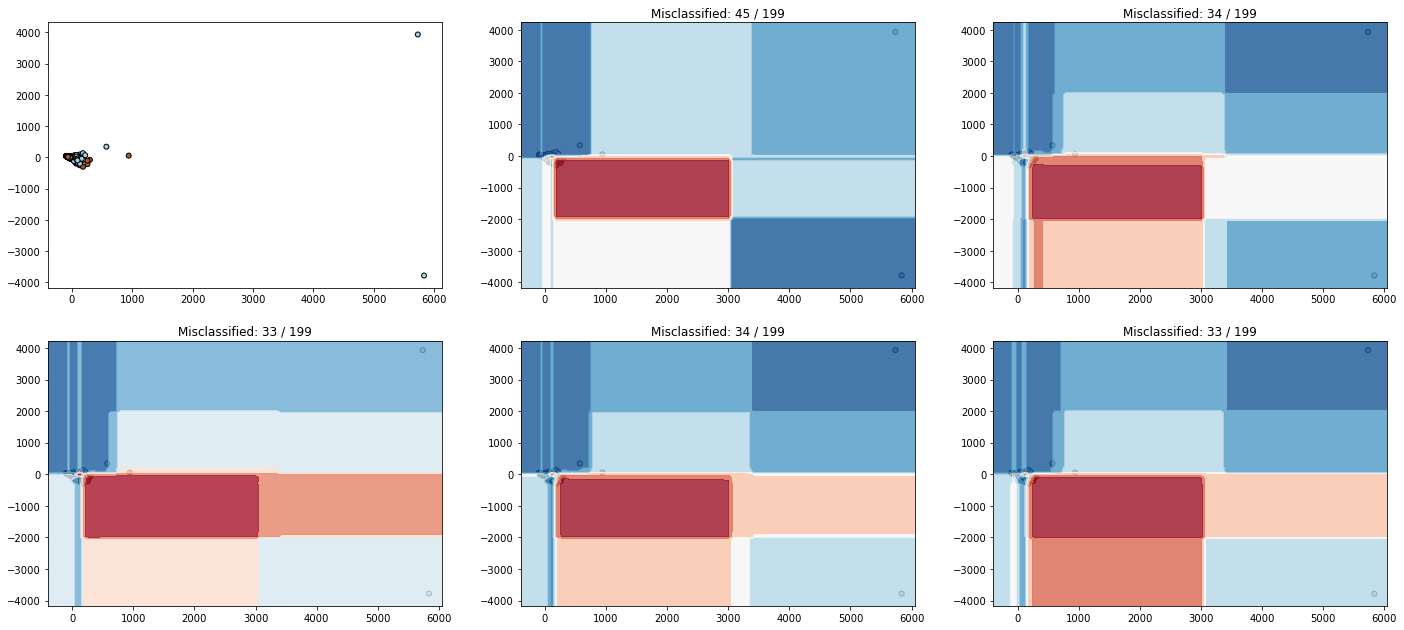

In [ ]:
# Random forest
# Bootstrapping is altijd beter
# boven 20 bomen is er geeen verbetering meer
X = x_train_trans
Y = y_train

clsfs = [RandomForestClassifier(n_estimators=5, bootstrap=True),
         RandomForestClassifier(n_estimators=50, bootstrap=True),
         RandomForestClassifier(n_estimators=100, bootstrap=True),
         RandomForestClassifier(n_estimators=200, bootstrap=True),
         RandomForestClassifier(n_estimators=20, bootstrap=True)]

# First make plot without classifiers:
num = 0
fig = plt.figure(figsize=(24,8*len(clsfs)))
ax = fig.add_subplot(7, 3, num + 1)
ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
    s=25, edgecolor='k', cmap=plt.cm.Paired)
num += 1
    
# Now use the classifiers on all datasets
for clf in clsfs:
    clf.fit(X, Y)
    ax = fig.add_subplot(7, 3, num + 1)
    ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
        s=25, edgecolor='k', cmap=plt.cm.Paired)
    colorplot(clf, ax, X[:, 0], X[:, 1])
    y_pred = clf.predict(x_val_trans)
    t = ("Misclassified: %d / %d" % ((y_val != y_pred).sum(), x_val_trans.shape[0]))
    ax.set_title(t)
    num += 1


In [ ]:
# SVM

X = x_train_trans
Y = y_train

degrees = [0.1, 1, 3, 5]
coef0s = [0.01, 0.5, 1]
slacks = [0.01, 0.5, 1]

clsfs = list()
for degree in degrees:
    for coef0 in coef0s:
        for slack in slacks:
            clsfs.append(SVC(kernel='poly', degree=degree, coef0=coef0, C=slack, gamma='scale'))

num = 0
fig = plt.figure(figsize=(24,8*len(clsfs)))
ax = fig.add_subplot(len(clsfs) + 1, 3, num + 1)
ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
    s=25, edgecolor='k', cmap=plt.cm.Paired)
num += 1

for clf in clsfs:
    clf.fit(X, Y)
    ax = fig.add_subplot(len(clsfs) + 1, 3, num + 1)
    ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
        s=25, edgecolor='k', cmap=plt.cm.Paired)
    colorplot(clf, ax, X[:, 0], X[:, 1])
    y_pred = clf.predict(x_val_trans)
    t = f"degree: {clf.degree}, coef0: {clf.coef0}, C: {clf.C}. "
    t = t + ("Misclassified: %d / %d" % ((y_val != y_pred).sum(), x_val_trans.shape[0]))
    ax.set_title(t)
    num += 1

ValueError: ignored

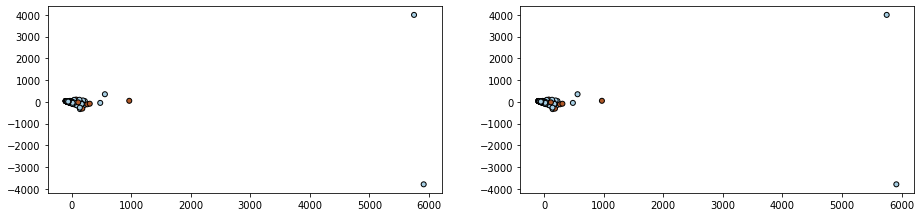

In [ ]:
# kernels

# First make plot without classifiers:
num = 0
fig = plt.figure(figsize=(24,8*3))
ax = fig.add_subplot(5 + 1, 3, num + 1)
ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
    s=25, edgecolor='k', cmap=plt.cm.Paired)
num += 1
    
# Option 1: use the standard RBF kernel from the scikit-learn SVM
clf = SVC(kernel='rbf', gamma=1)
clf.fit(X, Y)
ax = fig.add_subplot(5 + 1, 3, num + 1)
ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
    s=25, edgecolor='k', cmap=plt.cm.Paired)
colorplot(clf, ax, X[:, 0], X[:, 1])
y_pred = clf.predict(X)
t = ("Misclassified: %d / %d" % ((Y != y_pred).sum(), X.shape[0]))
ax.set_title(t)
num += 1
        

# Option 2: Manually transform the feature space with an RBF kernel, sample a part of this, than apply a linear SVM
rbf_feature = RBFSampler(gamma=1, random_state=1)
clf = SVC(kernel='linear')
XR = rbf_feature.fit_transform(X)
clf.fit(XR, Y)
ax = fig.add_subplot(5 + 1, 3, num + 1)
ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
    s=25, edgecolor='k', cmap=plt.cm.Paired)
colorplot(clf, ax, X[:, 0], X[:, 1], precomputer=rbf_feature)
y_pred = clf.predict(XR)
t = ("Misclassified: %d / %d" % ((Y != y_pred).sum(), X.shape[0]))
ax.set_title(t)
num += 1
    
# Option 3: supply a manually constructed kernel function to the SVM
clf = SVC(kernel=rbf_kernel)
clf.fit(X, Y)
ax = fig.add_subplot(5 + 1, 3, num + 1)
ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
    s=25, edgecolor='k', cmap=plt.cm.Paired)
colorplot(clf, ax, X[:, 0], X[:, 1])
y_pred = clf.predict(X)
t = ("Misclassified: %d / %d" % ((Y != y_pred).sum(), X.shape[0]))
ax.set_title(t)
num += 1

# Option 4: precompute the RBF kernel
clf = SVC(kernel='precomputed')
rbf_kernel_computed = rbf_kernel(X)
clf.fit(rbf_kernel_computed, Y)
ax = fig.add_subplot(5 + 1, 3, num + 1)
ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
    s=25, edgecolor='k', cmap=plt.cm.Paired)
colorplot(clf, ax, X[:, 0], X[:, 1], precomputer=rbf_kernel)
y_pred = clf.predict(rbf_kernel_computed)
t = ("Misclassified: %d / %d" % ((Y != y_pred).sum(), X.shape[0]))
ax.set_title(t)
num += 1
    
# Extra: use a totally different kernel!
clf = SVC(kernel=sigmoid_kernel)
clf.fit(X, Y)
ax = fig.add_subplot(5 + 1, 3, num + 1)
ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
    s=25, edgecolor='k', cmap=plt.cm.Paired)
colorplot(clf, ax, X[:, 0], X[:, 1])
y_pred = clf.predict(X)

t = ("Misclassified: %d / %d" % ((Y != y_pred).sum(), X.shape[0]))
ax.set_title(t)
num += 1

In [ ]:

X = x_train_trans
Y = y_train

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [10, 100, 1000]},
                    {'kernel': ['sigmoid'], 'C': [10,100,1000]}]
scores = ['precision', 'recall']


for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X, Y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_val, clf.predict(x_val_trans)
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for precision



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Pr

Best parameters set found on development set:

{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}

Grid scores on development set:

0.411 (+/-0.004) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.822 (+/-0.415) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.411 (+/-0.004) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.822 (+/-0.415) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.411 (+/-0.004) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.822 (+/-0.415) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.770 (+/-0.199) for {'C': 10, 'kernel': 'linear'}
0.770 (+/-0.199) for {'C': 100, 'kernel': 'linear'}
0.770 (+/-0.199) for {'C': 1000, 'kernel': 'linear'}
0.629 (+/-0.159) for {'C': 10, 'kernel': 'sigmoid'}
0.585 (+/-0.137) for {'C': 100, 'kernel': 'sigmoid'}
0.584 (+/-0.112) for {'C': 1000, 'kernel': 'sigmoid'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    rec

In [ ]:
from sklearn.linear_model import RidgeClassifier
from sklearn.datasets import load_iris
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

rc = RidgeClassifier(alpha=0.001, class_weight='balanced')

rc.fit(x_train_trans, y_train)
score = rc.score(x_train_trans, y_train)
print("Score: ", score)

cv_scores = cross_val_score(rc, x_train_trans, y_train, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

ypred = rc.predict(x_val_trans)

cm = confusion_matrix(y_val, ypred)
print(cm)
cr = classification_report(y_val, ypred)
print(cr)


Score:  0.7489177489177489
CV average score: 0.76
[[122  34]
 [ 31  12]]
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       156
           1       0.26      0.28      0.27        43

    accuracy                           0.67       199
   macro avg       0.53      0.53      0.53       199
weighted avg       0.68      0.67      0.68       199

